In [0]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import torch

import os
from sklearn.metrics import silhouette_score
import umap

import matplotlib.pyplot as plt
from matplotlib import colors as mcolors

In [0]:
# !pip install -U sentence-transformers

In [6]:
from sentence_transformers import SentenceTransformer

In [7]:
# mount google drive
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
data_path = os.path.join('gdrive', 'My Drive', 'Colab Notebooks', 'text_clustering', 'million-headlines', 'abcnews-date-text.csv')

In [9]:
# dataframe
df_all = pd.read_csv(data_path)

# get year from date and put that in a new column "year"
df_all['year'] = df_all['publish_date'].apply(lambda s: str(s)[:4])

print('shape of dataframe:', df_all.shape)

shape of dataframe: (1103663, 3)


In [10]:
print('number of news headlines in different years:')
print(df_all.groupby('year')['year'].count())

number of news headlines in different years:
year
2003    64003
2004    72674
2005    73124
2006    66912
2007    77192
2008    80014
2009    76454
2010    74948
2011    77829
2012    89109
2013    92337
2014    82330
2015    77941
2016    54614
2017    44182
Name: year, dtype: int64


In [11]:
# get news headlines from 2017 only
df = df_all.loc[df_all['year'] == "2017"]

print('shape of dataframe:', df.shape)

shape of dataframe: (44182, 3)


In [12]:
sentences = df['headline_text'].values
print('headlines:')
print(sentences)

headlines:
['1986 queensland cabinet documents released'
 'actor william cristopher mash chaplain dead at 84'
 'adelaide hip hop artist dreams becoming influential in australia' ...
 'what 2017 meant to the kids of australia'
 'what the papodopoulos meeting may mean for ausus'
 'who is george papadopoulos the former trump campaign aide']


In [13]:
# ROBERTA embeddings
model = SentenceTransformer('roberta-base-nli-mean-tokens')

sentence_embs = model.encode(sentences=sentences, batch_size=256, show_progress_bar=True)

# stack embs
sentence_embs = np.stack(sentence_embs)
print(sentence_embs.shape)

100%|██████████| 459M/459M [00:39<00:00, 11.7MB/s]
Batches: 100%|██████████| 173/173 [00:34<00:00,  4.94it/s]


(44182, 768)


In [0]:
################
# kmeans utils #
################

def forgy(X, n_clusters):
    _len = len(X)
    indices = np.random.choice(_len, n_clusters, replace=False)
    initial_state = X[indices]
    return initial_state


def do_kmeans_clustering(X, n_clusters, distance='euclidean', tol=1e-4, device=torch.device('cpu')):
    print(f'k-means clustering on {device}..')

    if distance == 'euclidean':
        pairwise_distance_function = pairwise_distance
    elif distance == 'cosine':
        pairwise_distance_function = pairwise_cosine
    else:
        raise NotImplementedError

    X = X.float()
    # transfer to device
    X = X.to(device)

    initial_state = forgy(X, n_clusters)

    iteration = 0
    tqdm_meter = tqdm()
    while True:
        dis = pairwise_distance_function(X, initial_state)

        choice_cluster = torch.argmin(dis, dim=1)

        initial_state_pre = initial_state.clone()

        for index in range(n_clusters):
            selected = torch.nonzero(choice_cluster == index).squeeze().to(device)

            selected = torch.index_select(X, 0, selected)
            initial_state[index] = selected.mean(dim=0)

        center_shift = torch.sum(torch.sqrt(torch.sum((initial_state - initial_state_pre) ** 2, dim=1)))

        # increment iteration
        iteration = iteration + 1

        # update tqdm meter
        tqdm_meter.set_postfix(iteration=f'{iteration}', center_shift=f'{center_shift ** 2}', tol=f'{tol}')

        if center_shift ** 2 < tol:
            break

    return choice_cluster.cpu(), initial_state.cpu()


def kmeans_predict(X, cluster_centers, distance='euclidean', device=torch.device('cpu')):
    print(f'predicting on {device}..')

    if distance == 'euclidean':
        pairwise_distance_function = pairwise_distance
    elif distance == 'cosine':
        pairwise_distance_function = pairwise_cosine
    else:
        raise NotImplementedError

    X = X.float()
    # transfer to device
    X = X.to(device)

    dis = pairwise_distance_function(X, cluster_centers)
    choice_cluster = torch.argmin(dis, dim=1)

    return choice_cluster.cpu()


'''
calculation of pairwise distance, and return condensed result,
 i.e. we omit the diagonal and duplicate entries and store 
 everything in a one-dimensional array
'''


def pairwise_distance(data1, data2=None, device=torch.device('cpu')):
    r'''
    using broadcast mechanism to calculate pairwise euclidean distance of data
    the input data is N*M matrix, where M is the dimension
    we first expand the N*M matrix into N*1*M matrix A and 1*N*M matrix B
    then a simple elementwise operation of A and B will handle the pairwise operation of points represented by data
    '''
    if data2 is None:
        data2 = data1

    data1, data2 = data1.to(device), data2.to(device)

    # N*1*M
    A = data1.unsqueeze(dim=1)

    # 1*N*M
    B = data2.unsqueeze(dim=0)

    dis = (A - B) ** 2.0
    # return N*N matrix for pairwise distance
    dis = dis.sum(dim=-1).squeeze()
    return dis


def pairwise_cosine(data1, data2=None, device=torch.device('cpu')):
    r'''
    using broadcast mechanism to calculate pairwise cosine distance of data
    the input data is N*M matrix, where M is the dimension
    we first expand the N*M matrix into N*1*M matrix A and 1*N*M matrix B
    then a simple elementwise operation of A and B will handle the pairwise operation of points represented by data
    '''
    if data2 is None:
        data2 = data1

    data1, data2 = data1.to(device), data2.to(device)

    # N*1*M
    A = data1.unsqueeze(dim=1)

    # 1*N*M
    B = data2.unsqueeze(dim=0)

    # normalize the points  | [0.3, 0.4] -> [0.3/sqrt(0.09 + 0.16), 0.4/sqrt(0.09 + 0.16)] = [0.3/0.5, 0.4/0.5]
    A_normalized = A / A.norm(dim=-1, keepdim=True)
    B_normalized = B / B.norm(dim=-1, keepdim=True)

    cosine = A_normalized * B_normalized

    # return N*N matrix for pairwise distance
    cosine_dis = 1 - cosine.sum(dim=-1).squeeze()
    return cosine_dis


def group_pairwise(X, groups, device=torch.device('cpu'), fun=lambda r, c: pairwise_distance(r, c).cpu()):
    group_dict = {}
    for group_index_r, group_r in enumerate(groups):
        for group_index_c, group_c in enumerate(groups):
            R, C = X[group_r], X[group_c]
            R, C = R.to(device), C.to(device)
            group_dict[(group_index_r, group_index_c)] = fun(R, C)
    return group_dict


In [0]:
# set device
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [17]:
# find good k (number of clusters)

sil_scores = []
for k in [2, 3, 4, 5, 6]:
    # k-means clustering
    cluster_ids_x, cluster_centers = do_kmeans_clustering(
        X=torch.from_numpy(sentence_embs),
        n_clusters=k,
        distance='cosine',
        device=device
    )

    sil_scores.append(silhouette_score(sentence_embs, cluster_ids_x.numpy(), metric='cosine'))


0it [00:00, ?it/s]

k-means clustering on cuda:0..



0it [00:00, ?it/s, center_shift=986.3757934570312, iteration=1, tol=0.0001]
0it [00:01, ?it/s, center_shift=10.759209632873535, iteration=2, tol=0.0001]
0it [00:02, ?it/s, center_shift=4.087040901184082, iteration=3, tol=0.0001] 
0it [00:02, ?it/s, center_shift=0.9138568639755249, iteration=4, tol=0.0001]
0it [00:03, ?it/s, center_shift=0.20926456153392792, iteration=5, tol=0.0001]
0it [00:03, ?it/s, center_shift=0.05004855617880821, iteration=6, tol=0.0001]
0it [00:04, ?it/s, center_shift=0.01392871979624033, iteration=7, tol=0.0001]
0it [00:05, ?it/s, center_shift=0.004355108831077814, iteration=8, tol=0.0001]
0it [00:05, ?it/s, center_shift=0.0014004458207637072, iteration=9, tol=0.0001]
0it [00:06, ?it/s, center_shift=0.00039247440872713923, iteration=10, tol=0.0001]
0it [00:07, ?it/s, center_shift=8.913796045817435e-05, iteration=11, tol=0.0001] 

0it [00:00, ?it/s]

k-means clustering on cuda:0..




0it [00:00, ?it/s, center_shift=1639.1650390625, iteration=1, tol=0.0001]

0it [00:01, ?it/s, center_shift=9.172782897949219, iteration=2, tol=0.0001]

0it [00:01, ?it/s, center_shift=4.957887172698975, iteration=3, tol=0.0001]

0it [00:02, ?it/s, center_shift=4.736124038696289, iteration=4, tol=0.0001]

0it [00:03, ?it/s, center_shift=6.083503723144531, iteration=5, tol=0.0001]

0it [00:03, ?it/s, center_shift=5.989541053771973, iteration=6, tol=0.0001]

0it [00:04, ?it/s, center_shift=3.343107223510742, iteration=7, tol=0.0001]

0it [00:05, ?it/s, center_shift=1.3420056104660034, iteration=8, tol=0.0001]

0it [00:05, ?it/s, center_shift=0.5121117234230042, iteration=9, tol=0.0001]

0it [00:06, ?it/s, center_shift=0.23028433322906494, iteration=10, tol=0.0001]

0it [00:07, ?it/s, center_shift=0.11467945575714111, iteration=11, tol=0.0001]

0it [00:07, ?it/s, center_shift=0.05423583462834358, iteration=12, tol=0.0001]

0it [00:08, ?it/s, center_shift=0.03228544443845749, iteration=13

k-means clustering on cuda:0..





0it [00:00, ?it/s, center_shift=2988.74658203125, iteration=1, tol=0.0001]


0it [00:01, ?it/s, center_shift=37.93979263305664, iteration=2, tol=0.0001]


0it [00:02, ?it/s, center_shift=13.837861061096191, iteration=3, tol=0.0001]


0it [00:02, ?it/s, center_shift=8.488832473754883, iteration=4, tol=0.0001] 


0it [00:03, ?it/s, center_shift=4.426314830780029, iteration=5, tol=0.0001]


0it [00:04, ?it/s, center_shift=1.5813252925872803, iteration=6, tol=0.0001]


0it [00:04, ?it/s, center_shift=0.5187947750091553, iteration=7, tol=0.0001]


0it [00:05, ?it/s, center_shift=0.19809892773628235, iteration=8, tol=0.0001]


0it [00:06, ?it/s, center_shift=0.07191316783428192, iteration=9, tol=0.0001]


0it [00:06, ?it/s, center_shift=0.0657794252038002, iteration=10, tol=0.0001]


0it [00:07, ?it/s, center_shift=0.059340979903936386, iteration=11, tol=0.0001]


0it [00:08, ?it/s, center_shift=0.04833580553531647, iteration=12, tol=0.0001] 


0it [00:08, ?it/s, center_shift=0.0380338095

k-means clustering on cuda:0..






0it [00:00, ?it/s, center_shift=3888.236328125, iteration=1, tol=0.0001]



0it [00:01, ?it/s, center_shift=43.96247863769531, iteration=2, tol=0.0001]



0it [00:02, ?it/s, center_shift=13.258084297180176, iteration=3, tol=0.0001]



0it [00:02, ?it/s, center_shift=7.814388751983643, iteration=4, tol=0.0001] 



0it [00:03, ?it/s, center_shift=6.815295696258545, iteration=5, tol=0.0001]



0it [00:04, ?it/s, center_shift=7.474595546722412, iteration=6, tol=0.0001]



0it [00:05, ?it/s, center_shift=8.957352638244629, iteration=7, tol=0.0001]



0it [00:05, ?it/s, center_shift=7.8095855712890625, iteration=8, tol=0.0001]



0it [00:06, ?it/s, center_shift=6.065053939819336, iteration=9, tol=0.0001] 



0it [00:07, ?it/s, center_shift=3.942141532897949, iteration=10, tol=0.0001]



0it [00:07, ?it/s, center_shift=2.8200554847717285, iteration=11, tol=0.0001]



0it [00:08, ?it/s, center_shift=2.6839637756347656, iteration=12, tol=0.0001]



0it [00:09, ?it/s, center_shift=2.77276396

k-means clustering on cuda:0..







0it [00:00, ?it/s, center_shift=5569.02294921875, iteration=1, tol=0.0001]




0it [00:01, ?it/s, center_shift=78.81867218017578, iteration=2, tol=0.0001]




0it [00:02, ?it/s, center_shift=29.945289611816406, iteration=3, tol=0.0001]




0it [00:03, ?it/s, center_shift=16.420434951782227, iteration=4, tol=0.0001]




0it [00:03, ?it/s, center_shift=11.204622268676758, iteration=5, tol=0.0001]




0it [00:04, ?it/s, center_shift=9.551791191101074, iteration=6, tol=0.0001] 




0it [00:05, ?it/s, center_shift=6.8542351722717285, iteration=7, tol=0.0001]




0it [00:06, ?it/s, center_shift=4.549101829528809, iteration=8, tol=0.0001] 




0it [00:06, ?it/s, center_shift=2.7788755893707275, iteration=9, tol=0.0001]




0it [00:07, ?it/s, center_shift=1.6170982122421265, iteration=10, tol=0.0001]




0it [00:08, ?it/s, center_shift=1.0646531581878662, iteration=11, tol=0.0001]




0it [00:09, ?it/s, center_shift=0.6508973836898804, iteration=12, tol=0.0001]




0it [00:09, ?it/s, cent

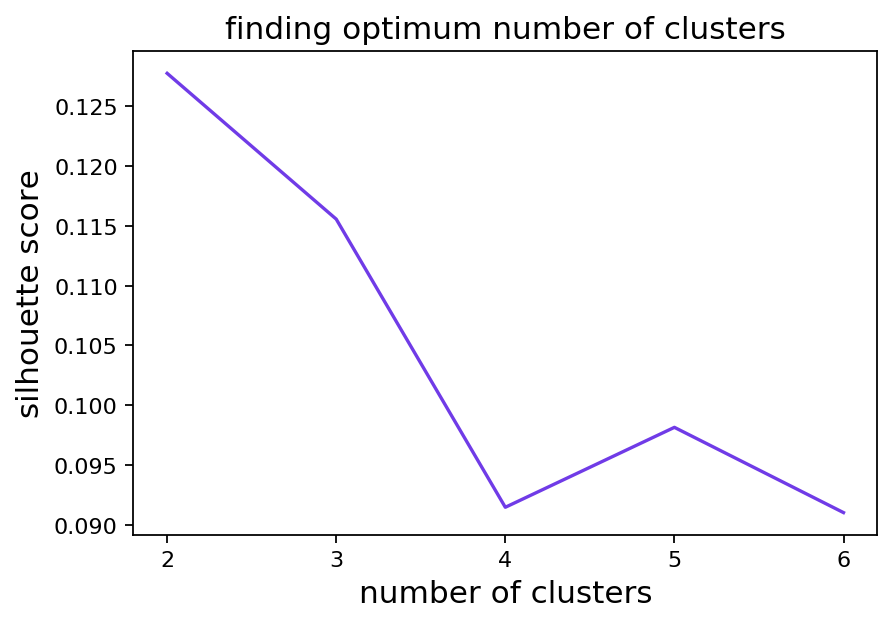

In [18]:
# plot silhouette scores
plt.figure(figsize=(6, 4), dpi=160)
plt.plot([2, 3, 4, 5, 6], sil_scores, color='xkcd:bluish purple')
plt.xticks([2, 3, 4, 5, 6])
plt.xlabel('number of clusters', fontsize=14)
plt.ylabel('silhouette score', fontsize=14)
plt.title('finding optimum number of clusters', fontsize=14)
plt.show()

In [19]:
# cluster using k with max silhoutte score
num_clusters = np.argmax(sil_scores) + 2  # 0th index means 2 clusters, ..

cluster_ids_x, cluster_centers = do_kmeans_clustering(
    X=torch.from_numpy(sentence_embs),
    n_clusters=num_clusters,
    distance='cosine',
    device=device
)







0it [00:00, ?it/s]

k-means clustering on cuda:0..








0it [00:00, ?it/s, center_shift=727.1110229492188, iteration=1, tol=0.0001]





0it [00:01, ?it/s, center_shift=5.462250709533691, iteration=2, tol=0.0001]





0it [00:01, ?it/s, center_shift=1.8403728008270264, iteration=3, tol=0.0001]





0it [00:02, ?it/s, center_shift=1.3697181940078735, iteration=4, tol=0.0001]





0it [00:03, ?it/s, center_shift=1.458274483680725, iteration=5, tol=0.0001] 





0it [00:03, ?it/s, center_shift=1.9710240364074707, iteration=6, tol=0.0001]





0it [00:04, ?it/s, center_shift=2.6261627674102783, iteration=7, tol=0.0001]





0it [00:05, ?it/s, center_shift=2.5986201763153076, iteration=8, tol=0.0001]





0it [00:05, ?it/s, center_shift=1.8747798204421997, iteration=9, tol=0.0001]





0it [00:06, ?it/s, center_shift=1.0184786319732666, iteration=10, tol=0.0001]





0it [00:06, ?it/s, center_shift=0.35858091711997986, iteration=11, tol=0.0001]





0it [00:07, ?it/s, center_shift=0.12216699868440628, iteration=12, tol=0.0001]





0it [00

In [21]:
# UMAP
emb_umap = umap.UMAP(metric='cosine', verbose=True).fit_transform(sentence_embs)

UMAP(a=None, angular_rp_forest=False, b=None, init='spectral',
     learning_rate=1.0, local_connectivity=1.0, metric='cosine',
     metric_kwds=None, min_dist=0.1, n_components=2, n_epochs=None,
     n_neighbors=15, negative_sample_rate=5, random_state=None,
     repulsion_strength=1.0, set_op_mix_ratio=1.0, spread=1.0,
     target_metric='categorical', target_metric_kwds=None,
     target_n_neighbors=-1, target_weight=0.5, transform_queue_size=4.0,
     transform_seed=42, verbose=True)
Construct fuzzy simplicial set
Sat Dec 21 01:36:12 2019 Finding Nearest Neighbors
Sat Dec 21 01:36:12 2019 Building RP forest with 16 trees
Sat Dec 21 01:36:16 2019 NN descent for 15 iterations
	 0  /  15
	 1  /  15
	 2  /  15
	 3  /  15
	 4  /  15
	 5  /  15
	 6  /  15
Sat Dec 21 01:37:04 2019 Finished Nearest Neighbor Search
Sat Dec 21 01:37:06 2019 Construct embedding
	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80

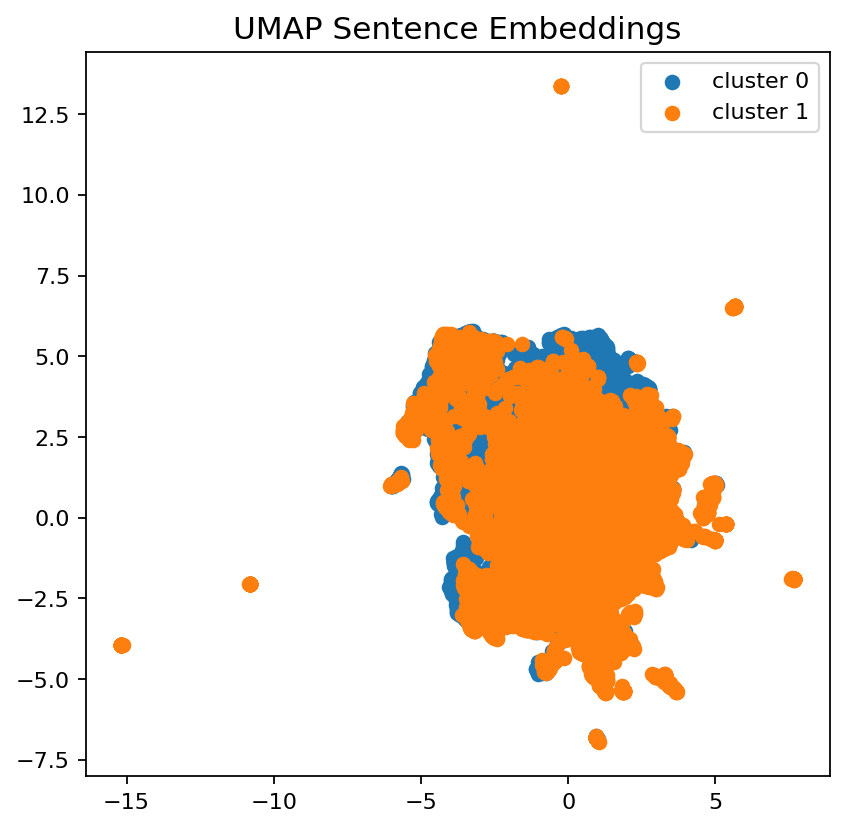

In [22]:
# plot
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
plt.figure(figsize=(6, 6), dpi=160)
for cluster_id in range(num_clusters):
    plt.scatter(
        emb_umap[cluster_ids_x == cluster_id][:, 0],
        emb_umap[cluster_ids_x == cluster_id][:, 1],
        color=cols[cluster_id],
        label=f'cluster {cluster_id}'
    )

plt.title('UMAP Sentence Embeddings', fontsize=14)
plt.legend(fontsize=10)
plt.show()

In [23]:
np.random.choice(sentences[cluster_ids_x == 0], 20, replace=False)

array(['war on waste pickling scraps and pineapple mocktails',
       'bendigo health ceo construction manager defrauded hospital ibac',
       'hunter valley boy battling cystinosis',
       'weatherill critical of broken national',
       'froome theres no benefit of the doubt when you fail a drug test',
       'man charged with murder following stabbing death',
       'gig economy workers missing out on superannuation',
       'girlfriend of las vegas gunman says she had no',
       'paypal faces class action over undelivered charity money',
       'weather disaster and emergency quiz',
       'elijah doughty trial man found not guilty of manslaughter',
       'sp downgrades banks credit rating on property crash risk',
       'ancient starfish like fossils unearthed in remote wa',
       'cricket in its worst state since world series aca says',
       'the squalor of jakartas detention centre',
       'adelaide fringe 41 seconds suicide',
       'turnbull deplores boycotts of israel

In [24]:
np.random.choice(sentences[cluster_ids_x == 1], 20, replace=False)

array(['catalan independence supporters react to article 155 move',
       'the federal government is seeks to extend the life',
       'gas reservation plan may alleviate energy crisis: shorten',
       'snowboard prodigy',
       'tuesday am glenorchy council general manager peter brooks out',
       'building earthquake proof buildings in nepal',
       'older people meeting new mates via community visitor program',
       'nsw liberal mp peter phelps compares school health',
       'a gentle man',
       'satellite researcher urges australian space agency go ahead',
       'delirium patient who helped in breakthrough speaks',
       'disney buying large part of 21 century fox for 68 billion',
       'tennant creek residents want answers about asbestos housing',
       'dennis rodman to return to north korea',
       'rspca hosts catpacity campaign to push cat adoptions',
       'housing affordability package to be announced by nsw government',
       'aussie strongman and mental he